In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=0, float_l=0, aug_alpha=True),LossTracker(),SaveBest('weights/best_ie0a.h5'),EarlyStopping(10)])

1: Train=366.854743347168 Valid=358.43709838867187
2: Train=353.850647277832 Valid=351.6737969970703
3: Train=348.13579498291017 Valid=345.4810400390625
4: Train=343.81221099853514 Valid=343.0934088134766
5: Train=340.04313598632814 Valid=337.7275860595703
6: Train=335.35754547119143 Valid=333.87962219238284
7: Train=332.9202005004883 Valid=331.5765631103516
8: Train=329.892880859375 Valid=327.58516479492187
9: Train=325.5723373413086 Valid=323.25989685058596
10: Train=320.68583053588867 Valid=317.40223388671876
11: Train=317.6191995239258 Valid=315.42116394042966
12: Train=315.91858367919923 Valid=312.06215393066407
13: Train=310.27828125 Valid=307.67860595703127
14: Train=308.4525927734375 Valid=305.2103790283203
15: Train=304.6080996704102 Valid=300.61045227050784
16: Train=297.80195419311525 Valid=295.8008258056641
17: Train=296.62194763183595 Valid=294.46284912109377
18: Train=294.73245727539063 Valid=293.0370556640625
19: Train=293.40824737548826 Valid=292.61517730712893
20: Trai

In [8]:
model.save('weights/Inferno_Test_exact_bm0a.h5')

In [9]:
model.load('weights/Inferno_Test_exact_bm0a.h5')

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,1,1.0
1,9,1.0
2,8,1.0
3,4,1.0
4,8,1.0


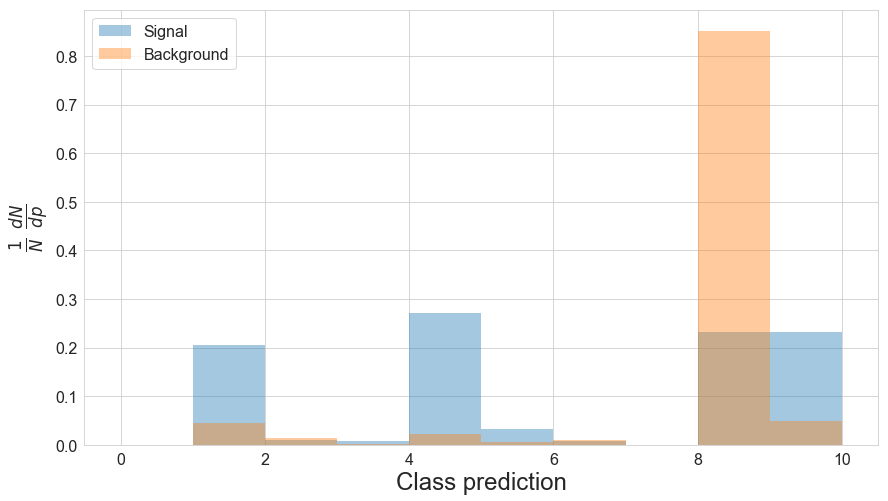

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [13]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,1,1.0,1
1,9,1.0,9
2,8,1.0,8
3,4,1.0,4
4,8,1.0,8


In [15]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.0000), tensor(1.0000))

In [17]:
f_s, f_b

(tensor([2.0000e-13, 2.0530e-01, 1.0830e-02, 6.8660e-03, 2.7154e-01, 3.2390e-02,
         8.5700e-03, 2.0000e-13, 2.3260e-01, 2.3191e-01]),
 tensor([2.0000e-13, 4.3976e-02, 1.3964e-02, 1.6160e-03, 2.2510e-02, 6.5380e-03,
         1.0592e-02, 2.0000e-13, 8.5201e-01, 4.8792e-02]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([2.1000e-10, 5.4241e+01, 1.4505e+01, 1.9593e+00, 3.6087e+01, 8.1575e+00,
         1.1021e+01, 2.1000e-10, 8.6364e+02, 6.0388e+01]), tensor(1049.9999))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([22.57548523, 22.4350853 , 22.30032539, 22.17166328, 22.04803467,
       21.93029213, 21.81783295, 21.71071625, 21.60876083, 21.5119133 ,
       21.42011642, 21.33431244, 21.25240898, 21.17536926, 21.10358047,
       21.03650284, 20.974123  , 20.91680527, 20.86356544, 20.81526184,
       20.77095032, 20.73147202, 20.69631195, 20.66542435, 20.63871574,
       20.61668968, 20.5982933 , 20.58395767, 20.57408524, 20.56824112,
       20.56628418, 20.56822395, 20.57397652, 20.58403778, 20.59731674,
       20.61435318, 20.63547897, 20.66032219, 20.6881752 , 20.72062302,
       20.75601959, 20.7954216 , 20.83771896, 20.88347054, 20.9335041 ,
       20.98598099, 21.04215431, 21.10210037, 21.16481018, 21.23065567,
       21.30018425, 21.37235069, 21.44761848, 21.52692795, 21.60876465,
       21.69364548, 21.78149605, 21.87228966, 21.96649361, 22.06359291,
       22.16259003])

In [21]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [22]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

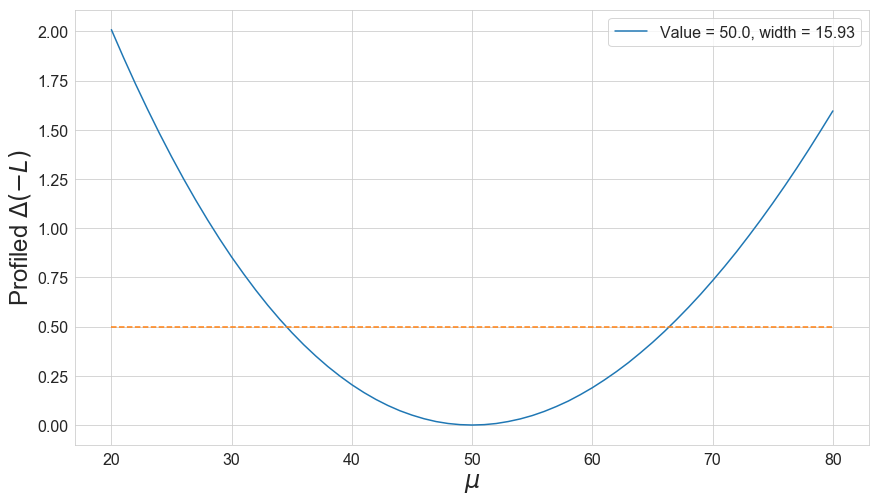

In [23]:
plot_likelihood(y-y.min())

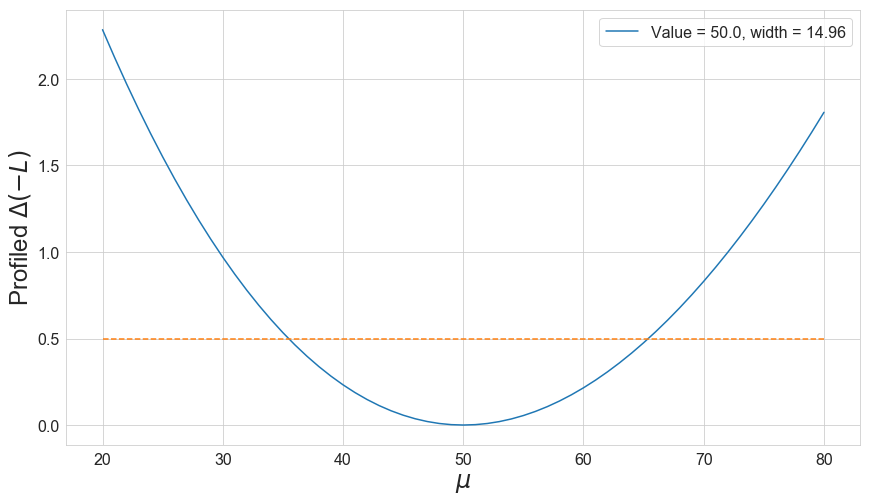

In [24]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [25]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [26]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [27]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,1,1.0,1,1,1,1,1,1,1,1,1,1,1
1,9,1.0,9,9,9,9,9,9,9,9,9,9,9
2,8,1.0,8,8,8,8,8,8,8,8,8,8,8
3,4,1.0,4,4,4,4,4,4,4,4,4,4,4
4,8,1.0,8,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999996,9,0.0,9,9,9,9,9,4,4,9,9,4,4
999997,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999998,8,0.0,8,8,8,8,8,8,8,8,8,8,8


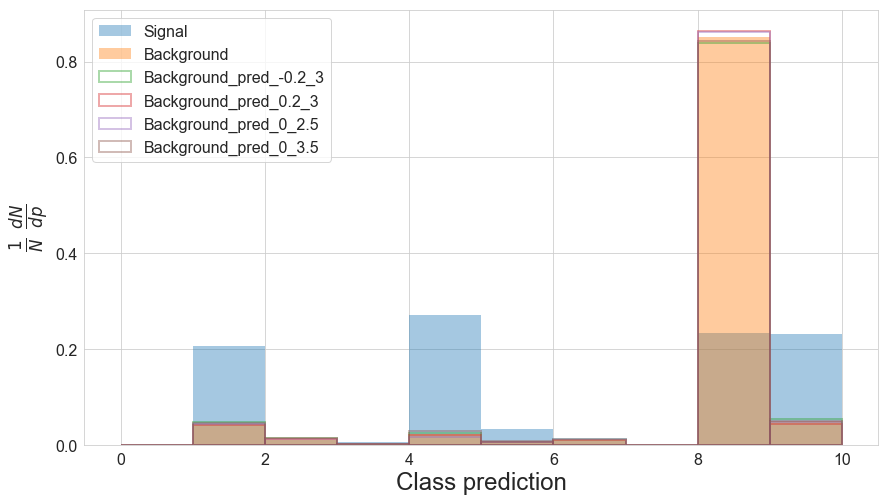

In [28]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([2.0000e-13, 4.6148e-02, 1.3712e-02, 1.2740e-03, 1.9398e-02, 4.9760e-03,
        1.3242e-02, 2.0000e-13, 8.4763e-01, 5.3616e-02])
tensor([2.0000e-13, 4.7324e-02, 1.4762e-02, 1.7180e-03, 2.4790e-02, 6.6500e-03,
        1.2002e-02, 2.0000e-13, 8.3866e-01, 5.4098e-02])
tensor([2.0000e-13, 4.8792e-02, 1.5740e-02, 2.1860e-03, 3.0524e-02, 8.3800e-03,
        1.0910e-02, 2.0000e-13, 8.2929e-01, 5.4176e-02])
tensor([2.0000e-13, 4.2800e-02, 1.2914e-02, 1.1720e-03, 1.7118e-02, 4.8640e-03,
        1.1832e-02, 2.0000e-13, 8.6099e-01, 4.8310e-02])
tensor([2.0000e-13, 4.3976e-02, 1.3964e-02, 1.6160e-03, 2.2510e-02, 6.5380e-03,
        1.0592e-02, 2.0000e-13, 8.5201e-01, 4.8792e-02])
tensor([2.0000e-13, 4.5444e-02, 1.4942e-02, 2.0840e-03, 2.8244e-02, 8.2680e-03,
        9.5000e-03, 2.0000e-13, 8.4265e-01, 4.8870e-02])
tensor([2.0000e-13, 3.9374e-02, 1.2070e-02, 1.0400e-03, 1.5026e-02, 4.6460e-03,
        1.0416e-02, 2.0000e-13, 8.7386e-01, 4.3570e-02])
tensor([2.0000e-13, 4.0550e-02, 1.3120e-0

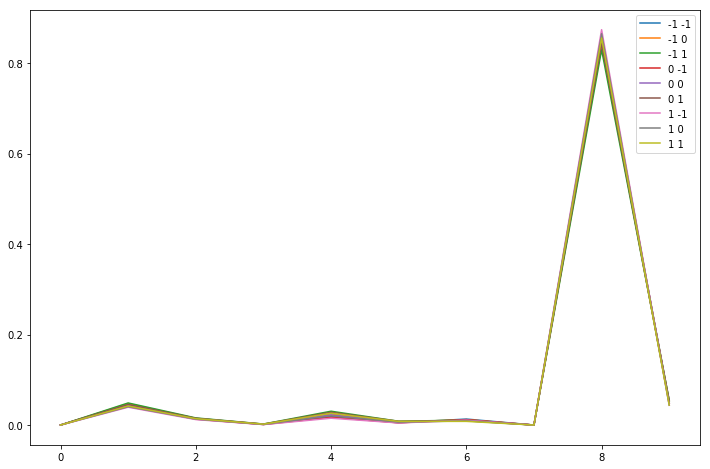

In [29]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [30]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [31]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [32]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.2369])
Linear regime: Mu 21.0, alpha tensor([-1.1935])
Linear regime: Mu 22.0, alpha tensor([-1.1503])
Linear regime: Mu 23.0, alpha tensor([-1.1073])
Linear regime: Mu 24.0, alpha tensor([-1.0644])
Linear regime: Mu 25.0, alpha tensor([-1.0216])
Linear regime: Mu 77.0, alpha tensor([1.0417])
Linear regime: Mu 78.0, alpha tensor([1.0783])
Linear regime: Mu 79.0, alpha tensor([1.1148])
Linear regime: Mu 80.0, alpha tensor([1.1511])


In [34]:
nll = to_np(nll)

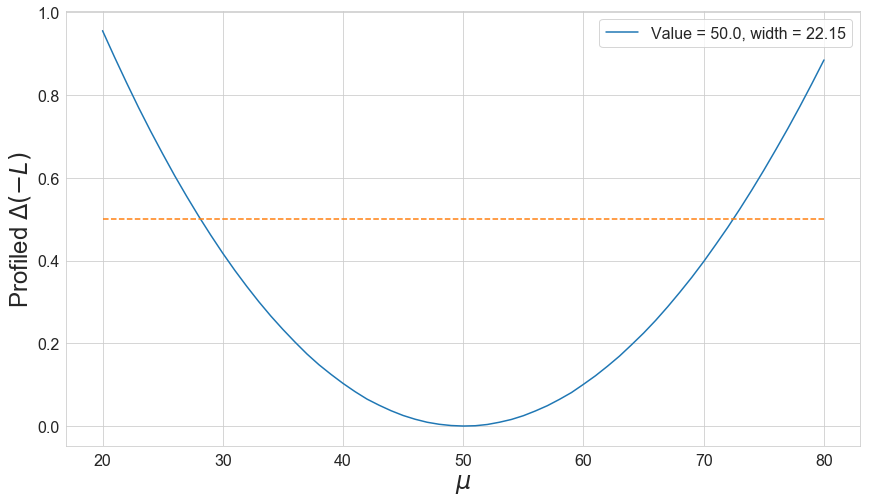

In [35]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [36]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [38]:
nll = to_np(nll)

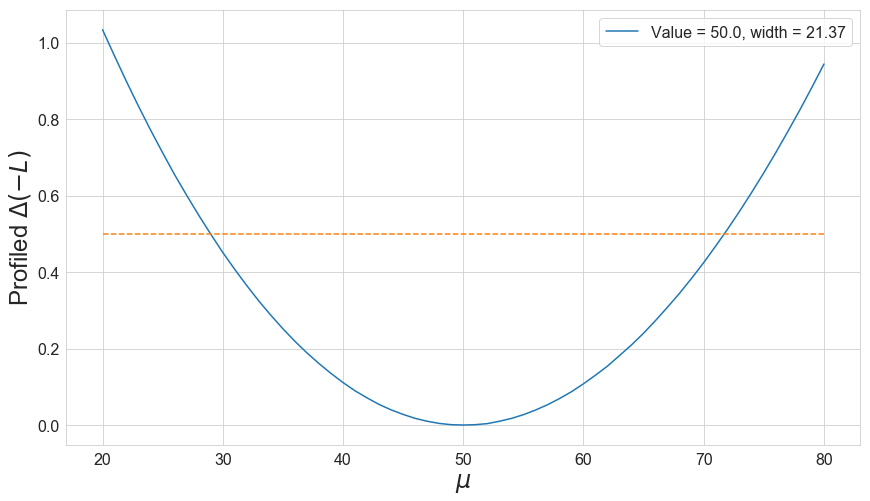

In [39]:
plot_likelihood(nll-nll.min())

## BM 2

In [40]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [41]:
nll = to_np(nll)

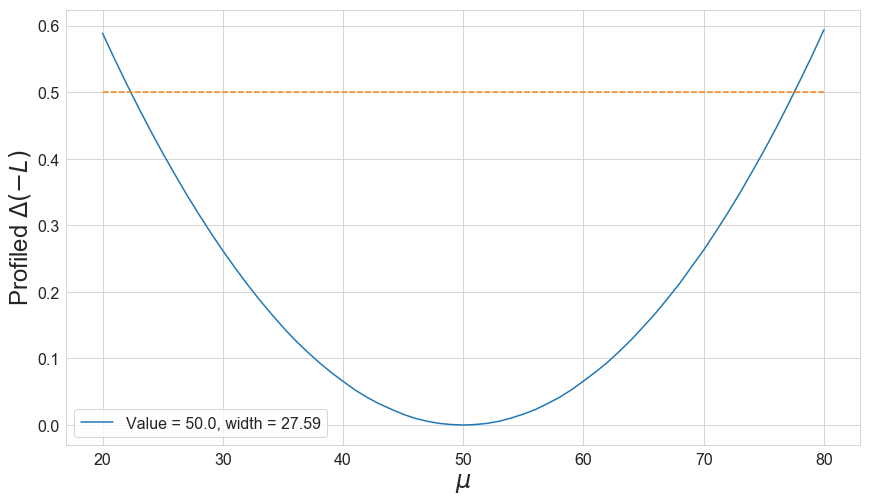

In [42]:
plot_likelihood(nll-nll.min())